In [27]:
use_cuda = True if torch.cuda.is_available() else False
print("YOU ARE USING CUDA ..." if use_cuda else "YOU ARE NOT USING CUDA ...")

YOU ARE USING CUDA ...


In [1]:
import torch
import torchvision.datasets as datasets

In [2]:
DATA_PATH = '/home/ujjwal/Desktop/BVAA/data/'

In [20]:
seed = 1024
train_batch_size = 64
test_batch_size = 1000
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
torch.manual_seed(seed)
epochs = 2
lr = 0.1
gamma = 0.7
log_interval = 1000
save_model = True

In [4]:
import torchvision.transforms as transforms

train_loader = torch.utils.data.DataLoader(datasets.MNIST(DATA_PATH, train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])), batch_size=train_batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST(DATA_PATH, train=False, download=True,
                                                        transform=transforms.Compose([
                                                            transforms.ToTensor(),
                                                            transforms.Normalize(
                                                            (0.1307,), (0.3081,))
                                                        ])), batch_size=test_batch_size, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

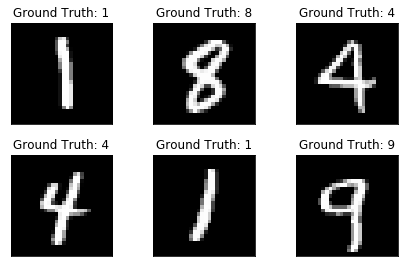

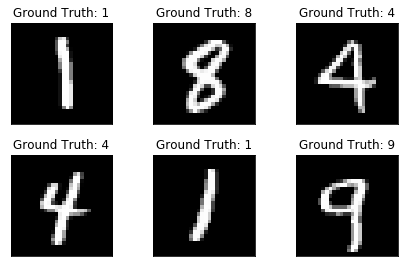

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [22]:
example_data[0].shape

torch.Size([1, 28, 28])

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
def conv(inch, ouch, ks, stride=2, pad=1, batchNorm=True):
    layers = []
    
    layers.append(nn.Conv2d(inch, ouch, ks, pad))
    
    if batchNorm:
        layers.append(nn.BatchNorm2d(ouch))
    
    return nn.Sequential(*layers)

In [84]:
class Encoder(nn.Module):
    def __init__(self, net_depth=4, conv_dim=64, img_dim=28, nc=1, z_dim=64):
        super(Encoder, self).__init__()
        self.net_depth = net_depth
        
        kernel_size = 4
        stride = 2
        pad = 1
        input_ch = nc
        output_ch = conv_dim
        
        self.encoder = []
        
        self.encoder.extend([conv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False), nn.LeakyReLU(0.05)])
        
        map_dim = (img_dim - kernel_size + 2 * pad) / stride + 1
        
        for i in range(1,net_depth):
            input_ch = output_ch
            output_ch = conv_dim*(2**i)
            self.encoder.extend([conv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False), nn.LeakyReLU(0.05)])
            map_dim = (map_dim - kernel_size + 2 * pad) / stride + 1
        
        self.encoder = nn.Sequential(*self.encoder)
#         print(output_ch*(map_dim**2))
#         int(output_ch*(map_dim**2))
        self.fc = nn.Linear(46208, 2048)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, z_dim)
    
    def num_features(self, x) :
        size = x.size()[1:]
        # all dim except the batch dim...
        num_features = 1
        for s in size :
            num_features *= s
        return num_features

    def encode(self, x):
        out = self.encoder(x)
        print(out.shape)
        out = out.view((-1, self.num_features(out)))
        print(out.shape)
        out = self.fc(out)
        out = F.leaky_relu(out, 0.05)
        out = self.fc1(out)
        out = F.leaky_relu(out, 0.05)
        out = self.fc2(out)
        return out
    
    def forward(self, x):
        return self.encode(x)

In [11]:
def deconv(inch, ouch, kernel_size, stride=2, pad=1, batchNorm=True):
    layers = []
    layers.append(nn.ConvTranspose2d(inch, ouch, kernel_size, stride, pad))
    if batchNorm:
        layers.append(nn.BatchNorm2d(ouch))
    return nn.Sequential(*layers)

In [123]:
class Decoder(nn.Module):
    def __init__(self, net_depth=4, conv_dim=64, img_dim=28, nc=1, z_dim=32):
        super(Decoder, self).__init__()
        self.net_depth = net_depth
        
        kernel_size = 4
        stride = 1
        pad = 1
        input_ch = z_dim
        output_ch = conv_dim*(2**self.net_depth)
        map_dim = kernel_size
        
        self.fc = deconv(input_ch, output_ch, kernel_size, stride=1, pad=0, batchNorm=False)
        
        self.decoder = []
        
        for i in reversed(range(self.net_depth)):
            input_ch = output_ch
            output_ch = output_ch*2
#             output_ch = conv_dim*(2**i)
            if i == 0:
                kernel_size = img_dim - stride*(map_dim-1) + 2*pad
                print("inside loop:",kernel_size)
            self.decoder.extend([deconv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False), nn.LeakyReLU(0.05)])
            map_dim = stride * (map_dim - 1) - 2 * pad + kernel_size 
        
        self.decoder = nn.Sequential(*self.decoder)
        
        input_ch = output_ch
        output_ch = 1
#         print(input_ch)
        output_dim = img_dim
        pad = 0
        stride = 1
#         kernel_size = output_dim + 2 * pad - stride * (map_dim - 1)
#         kernel_size = 3
        print("map:", map_dim)
        kernel_size = output_dim - (map_dim-1) * stride + 2*pad
        print("kernel_size:",kernel_size)
        self.final = deconv(input_ch, output_ch, kernel_size, stride, pad, batchNorm=False)
        
    def decode(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)
        out = F.leaky_relu(self.fc(z), 0.05)
        print("fc:",out.shape)
        out = F.leaky_relu(self.decoder(out), 0.05)
        print("decoder: ",out.shape)
        out = F.sigmoid(self.final(out))
        return out
    
    def forward(self, z):
        return self.decode(z)

In [74]:
class betaVAE(nn.Module):
    def __init__(self, net_depth=4, conv_dim=64, img_dim=28, nc=1, z_dim=32, beta=1.0, use_cuda=True):
        super(betaVAE, self).__init__()
        self.encoder = Encoder(net_depth, conv_dim, img_dim, nc, z_dim=2*z_dim)
        self.decoder = Decoder(net_depth, conv_dim, img_dim, nc, z_dim)
        self.beta = beta
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()
    
    def reparameterize(self, mu, log_var):
        eps = torch.randn(mu.size(), requires_grad=False).cuda()
        return mu + eps * torch.exp(log_var/2)
    
    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        out = self.decoder(z)
        return out, mu, log_var

In [14]:
class siamese(nn.Module):
    def __init__(self, image_size):
        super(siamse, self).__init__()
        self.cnn = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(3, 4, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8 * image_size * image_size, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 500),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Linear(500, 15)
        )
    
    def discriminator_embedding(self, x):
        output = self.cnn(x)
        output = output,view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, generator_model, original_input, phase='train'):
        if phase is 'train':
            generator_model.train()
        else:
            generator_model.eval()
        intermediate_input = generator_model(original_input)
        output_original = discriminator_embedding(original_input)
        output_generator = discriminator_embedding(intermediate_input)
        return output_original, output_generator

In [15]:
class Loss(nn.Module):
    def __init__(self, margin):
        super(Loss, self).__init__()
        self.margin = margin
    
    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        distance_from_margin = torch.clamp(torch.pow(euclidean_distance, 2) - self.margin, max=50.0)
        exp_distance_from_margin = torch.exp(distance_from_margin)
        distance_based_loss = (1.0 + math.exp(-self.margin)) / (1.0 + exp_distance_from_margin)
        similar_loss = -0.5 * (1 - label) * torch.log(distance_based_loss)
        dissimilar_loss = -0.5 * label * torch.log(1.0 - distance_based_loss)
        return torch.mean(similar_loss + dissimilar_loss)
    
    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [16]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin):
        """Set parameters of contrastive loss function."""
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """Define the computation performed at every call."""
        euclidean_distance = F.pairwise_distance(output1, output2)
        clamped = torch.clamp(self.margin - euclidean_distance, min=0.0)
        similar_loss = (1 - label) * 0.5 * torch.pow(euclidean_distance, 2)
        dissimilar_loss = label * 0.5 * torch.pow(clamped, 2)
        contrastive_loss = similar_loss + dissimilar_loss

        return torch.mean(contrastive_loss)

    def predict(self, output1, output2, threshold_factor=0.5):
        """Predict a dissimilarity label given two embeddings.
        Return `1` if dissimilar.
        """
        return F.pairwise_distance(output1, output2) > self.margin * threshold_factor

In [114]:
z_dim = 12
img_dim = example_data[0].shape[-1]
color_channels=1
conv_dim = 32
net_depth = 3
beta = 5e0

In [124]:
generator = betaVAE(beta=beta,
                    net_depth=net_depth,
                    z_dim=z_dim,
                    img_dim=img_dim,
                    nc=color_channels,
                    conv_dim=conv_dim, 
                    use_cuda=use_cuda
                   )

inside loop: 25
map: 28
kernel_size: 1


In [71]:
generator

betaVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
      )
      (1): LeakyReLU(negative_slope=0.05)
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
      )
      (3): LeakyReLU(negative_slope=0.05)
      (4): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
      )
      (5): LeakyReLU(negative_slope=0.05)
    )
    (fc): Linear(in_features=1568, out_features=2048, bias=True)
    (fc1): Linear(in_features=2048, out_features=1024, bias=True)
    (fc2): Linear(in_features=1024, out_features=24, bias=True)
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): ConvTranspose2d(12, 256, kernel_size=(4, 4), stride=(1, 1))
    )
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      )
      (1): LeakyReLU(negative_slope=0.05)
      (2): Sequent

In [50]:
# Optim :
lr = 1e-4
optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

# Debug :
# fixed inputs for debugging
fixed_z = torch.Tensor(torch.randn(100, z_dim))

In [51]:
if use_cuda:
    fixed_z = fixed_z.cuda()

In [57]:
import os

if not os.path.exists('./beta-data'):
    os.mkdir('./beta-data')

path = 'test--mnist-beta{}-layers{}-z{}-conv{}-lr{}'.format(beta,net_depth,z_dim,conv_dim,lr)

if not os.path.exists('./beta-data/{}/'.format(path)):
    os.mkdir('./beta-data/{}/'.format(path))

if not os.path.exists('./beta-data/{}/gen_images/'.format(path)):
    os.mkdir('./beta-data/{}/gen_images/'.format(path))

In [58]:
!ls

beta-data  model-latent-space.ipynb


In [60]:
data_iter = iter(train_loader)
iter_per_epoch = len(train_loader)
fixed_x, _ = next(data_iter)

In [62]:
from torchvision.utils import save_image
fixed_x = fixed_x.view( (-1, img_depth, img_dim, img_dim) )
save_image(fixed_x.cpu(), './beta-data/{}/real_images.png'.format(path))

In [64]:
fixed_x = torch.Tensor(fixed_x.view(fixed_x.size(0), img_depth, img_dim, img_dim))
if use_cuda:
    fixed_x = fixed_x.cuda()
out = torch.zeros((1,1))

In [65]:
sigma_mean = torch.ones((z_dim))
mu_mean = torch.zeros((z_dim))

In [129]:
size = 64
batch_size = 64

In [130]:
for epoch in range(50):
    reconsturcted_images, _, _ = generator(fixed_x)
    print(reconsturcted_images.shape)
    reconsturcted_images = reconsturcted_images.view(-1, color_channels, img_dim, img_dim)
    
    save_image(reconsturcted_images.data.cpu(),'./beta-data/{}/reconst_images_{}.png'.format(path,(epoch+1)))
    
    # Save generated variable images :
    nbr_steps = 8
    mu_mean /= batch_size
    sigma_mean /= batch_size
    gen_images = torch.ones((8, color_channels, img_dim, img_dim))
    
    for latent in range(z_dim):
        var_z0 = torch.zeros(nbr_steps, z_dim)
        val = mu_mean[latent] - sigma_mean[latent]
        step = 2.0 * sigma_mean[latent] / nbr_steps
        print(latent, mu_mean[latent], step)
        for i in range(nbr_steps) :
            var_z0[i] = mu_mean
            var_z0[i][latent] = val
            val += step

        var_z0 = Variable(var_z0)
        if use_cuda :
            var_z0 = var_z0.cuda()
        gen_images_latent = generator.decoder(var_z0)
        gen_images_latent = gen_images_latent.view(-1, img_depth, img_dim, img_dim).cpu().data
        gen_images = torch.cat([gen_images,gen_images_latent], dim=0)
    save_image(gen_images,'./beta-data/{}/gen_images/{}.png'.format(path,(epoch+1)) )

torch.Size([64, 128, 19, 19])
torch.Size([64, 46208])
fc: torch.Size([64, 256, 4, 4])


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 10.91 GiB total capacity; 9.19 GiB already allocated; 312.06 MiB free; 46.08 MiB cached)

In [ ]:
self.fc = nn.Linear(int(output_ch*(map_dim**2)), 2048)

In [68]:
class Distribution(object) :
    def sample(self) :
        raise NotImplementedError

    def log_prob(self,values) :
        raise NotImplementedError

class Bernoulli(Distribution) :
    def __init__(self, probs) :
        self.probs = probs

    def sample(self) :
        return torch.bernoulli(self.probs)

    def log_prob(self,values) :
        log_pmf = ( torch.stack( [1-self.probs, self.probs] ) ).log()
        dum = values.unsqueeze(0).long()
        return log_pmf.gather( 0, dum ).squeeze(0)

In [ ]:
for i, (images, _) in enumerate(data_loader):
    images = torch.Tensor((images.view(-1,1,img_dim, img_dim) ))
    if use_cuda :
        images = images.cuda() 

    out, mu, log_var = generator(images)

    mu_mean += torch.mean(mu.data,dim=0)
    sigma_mean += torch.mean(torch.sqrt(torch.exp(log_var.data)), dim=0 )

    # Compute :
    #reconstruction loss :
    reconst_loss = F.binary_cross_entropy(out, images, size_average=False)
    #reconst_loss = torch.mean( (out.view(-1) - images.view(-1))**2 )

    # expected log likelyhood :
    expected_log_lik = torch.mean(Bernoulli(out.view((-1))).log_prob(images.view((-1))))
    #expected_log_lik = torch.mean( Bernoulli( out ).log_prob( images ) )

    # kl divergence :
    #kl_divergence = 0.5 * torch.mean( torch.sum( (mu**2 + torch.exp(log_var) - log_var -1), dim=1) )
    kl_divergence = 0.5 * torch.sum( (mu**2 + torch.exp(log_var) - log_var -1) )

    # ELBO :
    elbo = expected_log_lik - generator.beta * kl_divergence

    # TOTAL LOSS :
    total_loss = reconst_loss + generator.beta*kl_divergence
    #total_loss = reconst_loss
    #total_loss = -elbo

    # Backprop + Optimize :
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print ("Epoch[%d/%d], Step [%d/%d], Total Loss: %.4f, "
               "Reconst Loss: %.4f, KL Div: %.7f, E[ |~| p(x|theta)]: %.7f " 
               %(epoch+1, 50, i+1, iter_per_epoch, total_loss.data[0], 
                 reconst_loss.data[0], kl_divergence.data[0],expected_log_lik.exp().data[0]) )

In [18]:
nn.Module._module

AttributeError: type object 'Module' has no attribute '_module'